In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.metrics import roc_curve, auc
import scipy
from scipy.stats import wilcoxon

In [84]:
k=15
#img_path ='C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(k,k,k)
img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_nifti_pet/{}_nifti_pet.img'.format(k,k,k)
img = nib.load(img_path)
img_data = img.get_fdata()
print(img_data.shape[2])
img= img_data[:,:,12]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
#plt.imshow(img,cmap='gray')
#fig=plt.gcf()
#plt.axis('off')
#fig.savefig('hypofig',bbox_inches='tight')

40


In [2]:
#choose negative and positive slices from the 1st data set

posPatients = np.concatenate((np.array([2,4,5,7,9,11,12,13,16,17,18,19,21,22]),range(23,109)))
locList = []
img_height = 128

#find locations of the positive slices from the binary masks
for i in range(len(posPatients)):
    if posPatients[i]<23:
        if posPatients[i]==12:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/12_anon/12_maski/12_maskit.img'
        else:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        if posPatients[i]==23:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/23/23_maski/23_nifti_maski_edit.img'
        if posPatients[i]==24:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/24/24_maski/24_maski.img'
        if posPatients[i]==38:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/38/38_nifti_maski/38_nifti_maski_edit.img'
        if posPatients[i] not in [23,24,38]:    
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_maski/{}_nifti_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    locations = []
    for j in range(img_data.shape[2]):
        slice = img_data[:,:,j]
        if np.max(slice)>0:
            locations.append(j)
    locList.append(np.array(locations))

posList = []

#choose positive slices from the given locations
for i in range(len(posPatients)):
    if posPatients[i]<23:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    pos = []
    for j in range(len(locList[i])):
        pos.append(cv2.resize(img_data[:,:,locList[i][j]],(img_height,img_height)))
    posList.append(pos)

negPatients = np.concatenate((np.array([1,2,4,6,10,11,12,14,15,16,18,22,23,24,25,26,28,31,33,34,36,38,39,41,43,44,45,47,48]),
                              range(51,63),range(64,123)))
negList = []

#choose random negative slices
for i in range(len(negPatients)):
    if negPatients[i]<49:
        img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/N{}_nifti_pet/N{}_nifti_pet.img'.format(
            negPatients[i],negPatients[i],negPatients[i])
    else:
        img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/{}_nifti_pet/{}_nifti_pet.img'.format(
            negPatients[i],negPatients[i],negPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    neg = []
    if i<15:
        number=12
    else:
        number=11
    indexes=np.random.choice(range(img_data.shape[2]),size=number,replace=False)
    maxValues=[]
    for j in range(number):
        maxValues.append(np.max(cv2.resize(img_data[:,:,int(indexes[j])],(img_height,img_height))))
    while(np.min(maxValues)==0):
        indexes=np.random.choice(range(img_data.shape[2]),size=number,replace=False)
        maxValues=[]
        for j in range(number):
            maxValues.append(np.max(cv2.resize(img_data[:,:,int(indexes[j])],(img_height,img_height))))
    for j in range(number):
        neg.append(cv2.resize(img_data[:,:,int(indexes[j])],(img_height,img_height)))
    negList.append(neg)

In [3]:
#check number of slices in the original pet images

numberOfSlices=[]

for i in range(len(posPatients)):
    if posPatients[i]<23:
        if posPatients[i]==12:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/12_anon/12_maski/12_maskit.img'
        else:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        if posPatients[i]==23:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/23/23_maski/23_nifti_maski_edit.img'
        if posPatients[i]==24:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/24/24_maski/24_maski.img'
        if posPatients[i]==38:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/38/38_nifti_maski/38_nifti_maski_edit.img'
        if posPatients[i] not in [23,24,38]:    
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_maski/{}_nifti_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    numberOfSlices.append(img_data.shape[2])

for i in range(len(negPatients)):
    if negPatients[i]<49:
        img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/N{}_nifti_pet/N{}_nifti_pet.img'.format(
            negPatients[i],negPatients[i],negPatients[i])
    else:
        img_path='C:/Users/Oona/Documents/Tpc/hnc/anom_data/negatiiviset/{}/{}_nifti_pet/{}_nifti_pet.img'.format(
            negPatients[i],negPatients[i],negPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    numberOfSlices.append(img_data.shape[2])

print(min(numberOfSlices[0:99]))
print(max(numberOfSlices[0:99]))
print(min(numberOfSlices[100:199]))
print(max(numberOfSlices[100:199]))

32
66
32
48


In [3]:
#convert images into typical format

def convert(img):

    img=(img-np.min(img))/(np.max(img)-np.min(img))*255
    for i in range(128):
        for j in range(128):
            img[i,j]=int(img[i,j])
    return img.astype('int64')

for i in range(len(posList)):
    for j in range(len(posList[i])):
        posList[i][j]=convert(posList[i][j])

for i in range(len(negList)):
    for j in range(len(negList[i])):
        negList[i][j]=convert(negList[i][j])

In [5]:
#check the number of chosen slices
numberOfSlices=[]
for i in range(len(posList)):
    numberOfSlices.append(len(posList[i]))
print(len(posList))
print(min(numberOfSlices))
print(max(numberOfSlices))
print(sum(numberOfSlices))
print(sum(numberOfSlices)/5)

100
2
28
1115
223.0


In [4]:
#choose testSetIndexes

testSetPos1=np.concatenate((range(0,85,5),np.array([86,90,99])))
testSetPos2=np.concatenate((range(1,85,5),np.array([92,93,94,95,97])))
testSetPos3=np.concatenate((range(2,85,5),np.array([96,98])))
testSetPos4=np.concatenate((range(3,85,5),np.array([87,88,89])))
testSetPos5=np.concatenate((range(4,85,5),np.array([85,91])))

testSetNeg1=np.array(range(0,100,5))
testSetNeg2=np.array(range(1,100,5))
testSetNeg3=np.array(range(2,100,5))
testSetNeg4=np.array(range(3,100,5))
testSetNeg5=np.array(range(4,100,5))

numberOfSlices=np.zeros((10))
testSetIndexes=[testSetPos1,testSetPos2,testSetPos3,testSetPos4,testSetPos5,testSetNeg1,testSetNeg2,testSetNeg3,testSetNeg4,testSetNeg5]
for j in range(5):
    for i in range(len(posList)):
        if i in testSetIndexes[j]:
            numberOfSlices[j]+=len(posList[i])
for j in range(5,10):
    for i in range(len(negList)):
        if i in testSetIndexes[j]:
            numberOfSlices[j]+=len(negList[i])

print(numberOfSlices)

[223. 223. 223. 223. 223. 223. 223. 223. 223. 223.]


In [9]:
def divideIntoSets_hnc(posList,negList,testSetIndexes,k):

    testSetPos=[]
    trainSetPos=[]
    for i in range(len(posList)):
        if i in testSetIndexes[k]:
            for j in range(len(posList[i])):
                testSetPos.append(posList[i][j])
        else:
            for j in range(len(posList[i])):
                trainSetPos.append(posList[i][j])

    testSetNeg=[]
    trainSetNeg=[]
    for i in range(len(negList)):
        if i in testSetIndexes[5+k]:
            for j in range(len(negList[i])):
                testSetNeg.append(negList[i][j])
        else:
            for j in range(len(negList[i])):
                trainSetNeg.append(negList[i][j])

    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]

    for i in range(len(testSetPos)):
        x_test.append(testSetNeg[i])
        y_test.append(0)
        x_test.append(testSetPos[i])
        y_test.append(1)

    for i in range(len(trainSetPos)):
        x_train.append(trainSetNeg[i])
        y_train.append(0)
        x_train.append(trainSetPos[i])
        y_train.append(1) 

    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    y_test=np.array(y_test)

    return([x_train,y_train,x_test,y_test])

In [6]:
x_train,y_train,x_test,y_test=divideIntoSets_hnc(posList,negList,testSetIndexes,1)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

1784
1784
446
446


In [13]:
def loadImgs(type):

    img_height = 128

    if type=='cvd':
        filenames = os.listdir('C:/Users/Oona/Documents/Tpc/thr/covid/normal/')
        filenames1 = os.listdir('C:/Users/Oona/Documents/Tpc/thr/covid/cvd')
        imgs=[]
        for i in range(1500):
            img_path='C:/Users/Oona/Documents/Tpc/thr/covid/normal/{}'.format(filenames[i])
            img=cv2.imread(img_path)
            img=cv2.resize(img[:,:,0],(img_height,img_height))
            imgs.append(img)
            img_path1='C:/Users/Oona/Documents/Tpc/thr/covid/cvd/{}'.format(filenames1[i])
            img1=cv2.imread(img_path1)
            img1=cv2.resize(img1[:,:,0],(img_height,img_height))
            imgs.append(img1)

    if type=='pneu':
        filenames = os.listdir('C:/Users/Oona/Documents/Tpc/thr/pneumonia/normal')
        filenames1 = os.listdir('C:/Users/Oona/Documents/Tpc/thr/pneumonia/ill')
        imgs=[]
        for i in range(1500):
            img_path='C:/Users/Oona/Documents/Tpc/thr/pneumonia/normal/{}'.format(filenames[i])
            img=cv2.imread(img_path)
            img=cv2.resize(img[:,:,0],(img_height,img_height))
            imgs.append(img)
            img_path1='C:/Users/Oona/Documents/Tpc/thr/pneumonia/ill/{}'.format(filenames1[i])
            img1=cv2.imread(img_path1)
            img1=cv2.resize(img1[:,:,0],(img_height,img_height))
            imgs.append(img1)

    if type=='tbc':
        filenames = os.listdir('C:/Users/Oona/Documents/Tpc/thr/tuberculosis/normal')
        filenames1 = os.listdir('C:/Users/Oona/Documents/Tpc/thr/tuberculosis/tb')
        imgs=[]
        for i in range(700):
            img_path='C:/Users/Oona/Documents/Tpc/thr/tuberculosis/normal/{}'.format(filenames[i])
            img=cv2.imread(img_path)
            img=cv2.resize(img[:,:,0],(img_height,img_height))
            imgs.append(img)
            img_path1='C:/Users/Oona/Documents/Tpc/thr/tuberculosis/tb/{}'.format(filenames1[i])
            img1=cv2.imread(img_path1)
            img1=cv2.resize(img1[:,:,0],(img_height,img_height))
            imgs.append(img1)

    if type=='brh':
        filenames = os.listdir('C:/Users/Oona/Documents/Tpc/thr/br35h/no/')
        filenames1 = os.listdir('C:/Users/Oona/Documents/Tpc/thr/br35h/yes/')
        imgs=[]
        for i in range(1500):
            img_path='C:/Users/Oona/Documents/Tpc/thr/br35h/no/{}'.format(filenames[i])
            img=cv2.imread(img_path)
            img=cv2.resize(img[:,:,0],(img_height,img_height))
            imgs.append(img)
            img_path1='C:/Users/Oona/Documents/Tpc/thr/br35h/yes/{}'.format(filenames1[i])
            img1=cv2.imread(img_path1)
            img1=cv2.resize(img1[:,:,0],(img_height,img_height))
            imgs.append(img1)

    return(imgs)

In [14]:
def divideImgsIntoSets(imgs,k):

    numberOfImgs=len(imgs)
    testSetSize=int(numberOfImgs/5)
    trainSetSize=numberOfImgs-testSetSize
    x_train=np.array(imgs[0:(k*testSetSize)]+imgs[((k+1)*testSetSize):numberOfImgs])
    y_train=np.array([0,1]*int(trainSetSize/2))
    x_test=np.array(imgs[(k*testSetSize):((k+1)*testSetSize)])
    y_test=np.array([0,1]*int(testSetSize/2))

    return([x_train,y_train,x_test,y_test])

In [30]:
imgs=loadImgs('cvd')
x_train,y_train,x_test,y_test=divideImgsIntoSets(imgs,0)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

2528
2528
632
632


In [7]:
def predict(x_train,y_train,x_test,numEpochs):
    
    img_height=x_train[0].shape[0]
    if len(x_train.shape)==3:
        x_train=np.rollaxis(np.array([x_train,x_train,x_train]),0,4)
        x_test=np.rollaxis(np.array([x_test,x_test,x_test]),0,4)
    ntf_model = keras.applications.InceptionV3(weights=None,input_shape=(img_height,img_height,3),include_top=False)
    ntf_model.trainable = True
    inputs = keras.Input(shape=(img_height,img_height,3))
    x = ntf_model(inputs, training=True)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.SGD(1e-3),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])
    model.fit(x=x_train, y=y_train, epochs=numEpochs, validation_split=0.3, shuffle=True)
    ntfPredictions=model.predict(x_test)
    ntfTrainPreds=model.predict(x_train)
    return([ntfPredictions, ntfTrainPreds])

In [11]:
for j in range(5):
    for k in range(5):
        x_train,y_train,x_test,y_test=divideIntoSets_hnc(posList,negList,testSetIndexes,k)
        #print(len(x_test))
        predictions,trainPreds=predict(x_train,y_train,x_test,10)
        np.savetxt('thr_hnc_trainPreds_{}.txt'.format(5*j+k),trainPreds)
        np.savetxt('thr_hnc_predictions_{}.txt'.format(5*j+k),predictions)

Epoch 1/10
39/39 [==============================] - 191s 5s/step - loss: 0.6790 - binary_accuracy: 0.5288 - val_loss: 0.6347 - val_binary_accuracy: 0.5448
Epoch 2/10
39/39 [==============================] - 171s 4s/step - loss: 0.5878 - binary_accuracy: 0.6627 - val_loss: 0.5762 - val_binary_accuracy: 0.6754
Epoch 3/10
39/39 [==============================] - 163s 4s/step - loss: 0.5376 - binary_accuracy: 0.7236 - val_loss: 0.5521 - val_binary_accuracy: 0.7052
Epoch 4/10
39/39 [==============================] - 153s 4s/step - loss: 0.5191 - binary_accuracy: 0.7468 - val_loss: 0.5390 - val_binary_accuracy: 0.7313
Epoch 5/10
39/39 [==============================] - 152s 4s/step - loss: 0.5108 - binary_accuracy: 0.7540 - val_loss: 0.5369 - val_binary_accuracy: 0.7332
Epoch 6/10
39/39 [==============================] - 144s 4s/step - loss: 0.5092 - binary_accuracy: 0.7500 - val_loss: 0.5339 - val_binary_accuracy: 0.7313
Epoch 7/10
39/39 [==============================] - 143s 4s/step - los

In [15]:
for type in ['cvd','pneu','tbc','brh']:
    imgs=loadImgs(type)
    for j in range(5):
        for k in range(5):
            x_train,y_train,x_test,y_test=divideImgsIntoSets(imgs,k)
            predictions,trainPreds=predict(x_train,y_train,x_test,10)
            np.savetxt('thr_{}_trainPreds_{}.txt'.format(type,5*j+k),trainPreds)
            np.savetxt('thr_{}_predictions_{}.txt'.format(type,5*j+k),predictions)

Epoch 1/10
53/53 [==============================] - 208s 4s/step - loss: 0.6742 - binary_accuracy: 0.5536 - val_loss: 0.6468 - val_binary_accuracy: 0.5986
Epoch 2/10
53/53 [==============================] - 190s 4s/step - loss: 0.6149 - binary_accuracy: 0.6244 - val_loss: 0.6136 - val_binary_accuracy: 0.6472
Epoch 3/10
53/53 [==============================] - 191s 4s/step - loss: 0.5979 - binary_accuracy: 0.6548 - val_loss: 0.5936 - val_binary_accuracy: 0.6597
Epoch 4/10
53/53 [==============================] - 191s 4s/step - loss: 0.5614 - binary_accuracy: 0.6893 - val_loss: 0.5738 - val_binary_accuracy: 0.6708
Epoch 5/10
53/53 [==============================] - 191s 4s/step - loss: 0.5420 - binary_accuracy: 0.6964 - val_loss: 0.5587 - val_binary_accuracy: 0.6833
Epoch 6/10
53/53 [==============================] - 192s 4s/step - loss: 0.5206 - binary_accuracy: 0.7179 - val_loss: 0.5499 - val_binary_accuracy: 0.6972
Epoch 7/10
53/53 [==============================] - 191s 4s/step - los

In [2]:
def findThresholds(trainPreds):

    default=0.5
    y_train=np.array([0,1]*int(trainPreds.shape[0]/2))
    fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
    J_stats = tpr - fpr
    youden = thresholds[np.argmax(J_stats)]
    rocdists = (1-tpr)**2+fpr**2
    minRocDist = thresholds[np.argmin(rocdists)]
    equ=thresholds[np.argmin((tpr-1+fpr)**2)]
    c=0.5
    sendist=thresholds[np.argmin((1+c-tpr)**2+fpr**2)]
    sencp=thresholds[np.argmax(tpr*(1-fpr+c))]

    return([default,youden,minRocDist,equ,sendist,sencp])

In [3]:
def evaluatePreds(predictions,threshold):

    y_test=np.array([0,1]*int(predictions.shape[0]/2))

    TN = 0
    FN = 0
    TP = 0
    FP = 0

    for i in range(len(y_test)):
        if predictions[i]<threshold:
            if y_test[i]==0:
                TN+=1
            else:
                FN+=1
        else:
            if y_test[i]==1:
                TP+=1
            else:
                FP+=1

    acc = (TN+TP)/(TN+FN+TP+FP)
    sen = TP/(FN+TP)
    spe = TN/(TN+FP)
    f1 = TP/(TP+1/2*(FP+FN))
    nb = (TP-FP)/(TP+FP+TP+FN)

    return([acc,sen,spe,f1,nb])

In [4]:
def colMeans(data):

    numCols=data.shape[1]
    means=np.zeros((numCols))
    for i in range(numCols):
        means[i]=np.mean(data[:,i])

    return(means)

In [34]:
i=0
dataNames=['hnc','brh','cvd','pneu','tbc']
l=0
metricNames=['acc','sen','spec','f1','nb']
v_default=np.zeros((25))
v_youden=np.zeros((25))
v_minrocdist=np.zeros((25))
v_equal=np.zeros((25))
v_sendist=np.zeros((25))
v_sencp=np.zeros((25))

for j in range(25):
      trainPreds=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/thr_{}_trainPreds_{}.txt'.format(dataNames[i],j))
      predictions=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/thr_{}_predictions_{}.txt'.format(dataNames[i],j))
      v_default[j]=evaluatePreds(predictions,0.5)[l]
      thresholds=findThresholds(trainPreds)
      v_youden[j]=evaluatePreds(predictions,thresholds[1])[l]
      v_minrocdist[j]=evaluatePreds(predictions,thresholds[2])[l]
      v_equal[j]=evaluatePreds(predictions,thresholds[3])[l]
      v_sendist[j]=evaluatePreds(predictions,thresholds[4])[l]
      v_sencp[j]=evaluatePreds(predictions,thresholds[5])[l]

print(dataNames[i])
print(metricNames[l])
print('default',round(100*np.mean(v_default),1),round(100*np.std(v_default),1))
print('youden',round(100*np.mean(v_youden),1),round(100*np.std(v_youden),1))
print('minrocdist',round(np.mean(100*v_minrocdist),1),round(100*np.std(v_minrocdist),1))
print('equal',round(100*np.mean(v_equal),1),round(100*np.std(v_equal),1))
print('sendist',round(100*np.mean(v_sendist),1),round(100*np.std(v_sendist),1))
print('sencp',round(100*np.mean(v_sencp),1),round(100*np.std(v_sencp),1))

print(round(100*np.mean(v_default),1),'$\pm$',round(100*np.std(v_default),1),' & ',
      round(100*np.mean(v_youden),1),'$\pm$',round(100*np.std(v_youden),1),' & ',sep='')
print(round(np.mean(100*v_minrocdist),1),'$\pm$',round(100*np.std(v_minrocdist),1),' & ',
      round(100*np.mean(v_equal),1),'$\pm$',round(100*np.std(v_equal),1),' & ',sep='')
print(round(100*np.mean(v_sendist),1),'$\pm$',round(100*np.std(v_sendist),1),' & ',
      round(100*np.mean(v_sencp),1),'$\pm$',round(100*np.std(v_sencp),1),sep='')

hnc
acc
default 76.6 3.0
youden 78.1 3.3
minrocdist 78.4 3.0
equal 78.3 3.0
sendist 76.4 2.7
sencp 77.8 2.5
76.6$\pm$3.0 & 78.1$\pm$3.3 & 
78.4$\pm$3.0 & 78.3$\pm$3.0 & 
76.4$\pm$2.7 & 77.8$\pm$2.5


In [26]:
print(np.mean([76.6,69.3,76.9,86.2,65.9]))
print(np.mean([78.1,71.6,78.9,86.6,69.3]))
print(np.mean([78.4,71.6,79.0,86.4,69.3]))
print(np.mean([78.3,71.8,79.0,86.3,69.1]))
print(np.mean([76.4,70.7,77.4,84.3,69.3]))
print(np.mean([77.8,71.4,78.1,86.1,69.5]))

74.97999999999999
76.9
76.94
76.9
75.62
76.58


In [35]:
print('def vs equsen:',wilcoxon(v_default,v_equal))
print('def vs minrocdist:',wilcoxon(v_default,v_minrocdist))
print('def vs youden:',wilcoxon(v_default,v_youden))
print('youden vs equsen:',wilcoxon(v_youden,v_equal))
print('youden vs minrocdist:',wilcoxon(v_youden,v_minrocdist))
print('minrocdist vs equsen:',wilcoxon(v_minrocdist,v_equal))

def vs equsen: WilcoxonResult(statistic=3.5, pvalue=2.8107743897060393e-05)
def vs minrocdist: WilcoxonResult(statistic=1.5, pvalue=1.1920928955078125e-07)
def vs youden: WilcoxonResult(statistic=2.5, pvalue=2.439568033149616e-05)
youden vs equsen: WilcoxonResult(statistic=65.5, pvalue=0.6004626572836715)
youden vs minrocdist: WilcoxonResult(statistic=7.0, pvalue=0.06536424567212028)
minrocdist vs equsen: WilcoxonResult(statistic=49.5, pvalue=0.5479339138791671)


c:\Users\Oona\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\Oona\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [26]:
dataNames=['hnc','brh','cvd','pneu','tb']
v_auc=np.zeros((30))
print('auc')

for i in range(5):
    for j in range(6):
        for k in range(5):
            trainPreds=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/{}thr_{}_{}_trainPreds.txt'.format(j,dataNames[i],k+1))
            predictions=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/{}thr_{}_{}_predictions.txt'.format(j,dataNames[i],k+1))
            y_test=np.array([0,1]*int(predictions.shape[0]/2))
            fpr, tpr, thresholds = roc_curve(y_test, predictions, drop_intermediate=False)
            v_auc[5*j+k]=auc(fpr, tpr)
    print(dataNames[i],round(np.mean(v_auc),3),round(np.std(v_auc),3))

auc
hnc 0.816 0.076
brh 0.946 0.016
cvd 0.908 0.049
pneu 0.958 0.022
tb 0.953 0.019


In [20]:
def findSenDist(trainPreds,c):

    y_train=np.array([0,1]*int(trainPreds.shape[0]/2))
    fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
    sendist=thresholds[np.argmin((1+c-tpr)**2+fpr**2)]
    return(sendist)

def findSenCp(trainPreds,c):

    y_train=np.array([0,1]*int(trainPreds.shape[0]/2))
    fpr, tpr, thresholds = roc_curve(y_train, trainPreds, drop_intermediate=False)
    sencp=thresholds[np.argmax(tpr*(1-fpr+c))]
    return(sencp)

dataNames=['hnc','brh','cvd','pneu','tb']
v_c=0.05*np.array(range(10))
v_nbsendist=np.zeros((10,5))
v_nbsencp=np.zeros((10,5))

for i in range(5):
    for j in range(10):
        c=v_c[j]
        v_sendist=np.zeros((5))
        v_sencp=np.zeros((5))
        for k in range(5):
            trainPreds=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/thr_{}_{}_trainPreds.txt'.format(dataNames[i],k+1))
            predictions=np.loadtxt('C:/Users/Oona/Documents/Tpc/thr/results/thr_{}_{}_predictions.txt'.format(dataNames[i],k+1))
            sendist=findSenDist(trainPreds,c)
            sencp=findSenCp(trainPreds,c)
            v_sendist[k]=evaluatePreds(predictions,sendist)[3]
            v_sencp[k]=evaluatePreds(predictions,sencp)[3]
        v_nbsendist[j,i]=np.mean(v_sendist)
        v_nbsencp[j,i]=np.mean(v_sencp)

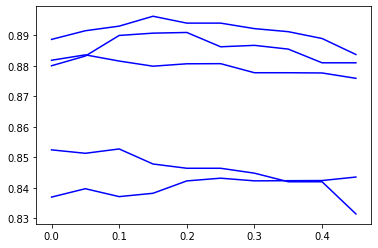

In [21]:
plt.plot(v_c,v_nbsendist[:,:],color='blue')